## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

This analysis will implement an A/B test run for an e-commerce website. The goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

#### Part I - Probability


In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv("ab_data.csv")
#Display the table to observe variables
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
#Calculate number of total rows
row = df['user_id'].count()
row

294478

c. The number of unique users in the dataset.

In [4]:
#Find and count only the unique unser ids
uni_user = df.groupby('user_id')['user_id'].nunique().sum()
uni_user

290584

d. The proportion of users converted.

In [5]:
#Find conversion ratio by taking number converted divided by total unique users
num_convert = df.query('converted == 1').user_id.count() / uni_user
num_convert

0.12126269856564711

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
#Sum up number of time new page and treatment don't line up
num_lineup = df.query('landing_page == "new_page" & group != "treatment"').user_id.count() + df.query('landing_page != "new_page" & group == "treatment"').user_id.count()
num_lineup

3893

f. Do any of the rows have missing values?

In [7]:
#Check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, it is more practical to remove these rows.

In [9]:
#Create a new dataframe that removes rows where new page and treatment don't line up or old page and group don't line up
df2 = df.copy()
df2 = df2.query('(landing_page == "new_page" & group == "treatment") | (landing_page == "old_page" & group == "control")')
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` 

a. How many unique **user_id**s are in **df2**?

In [11]:
#Find number of unique user ids in the new dataframe
uni_user2 = df2.groupby('user_id')['user_id'].nunique().sum()
uni_user2

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
#Retrieve the user id that repeated twice
df2[df2['user_id'].duplicated()].user_id.values[0]

773192

c. What is the row information for the repeat **user_id**? 

In [13]:
#Display row information for the user id above
dup = df2[df2['user_id'].duplicated()]
dup

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**.

In [14]:
#Remove the repeated user id
df2.drop(2893, axis=0, inplace=True)
df2['user_id'].duplicated().sum()

0

`4.`

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
#Calculate converted portion in total unique users
p_convert = df2[df2['converted'] == 1]['user_id'].count() / df2['user_id'].count()
p_convert

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
#Calculate converted portion in control group
p_control_convert = df2[(df2['converted'] == 1) & (df2['group'] == 'control')]['user_id'].count() / df2[df2['group'] == 'control']['user_id'].count()
p_control_convert

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
#Calculate converted portion in treatment group
p_treament_convert = df2[(df2['converted'] == 1) & (df2['group'] == 'treatment')]['user_id'].count() / df2[df2['group'] == 'treatment']['user_id'].count()
p_treament_convert

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
#Calculate portion of user that received the new page
p_newpage = df2[df2['landing_page'] == 'new_page']['user_id'].count() / df2['user_id'].count()
p_newpage

0.50006194422266881

e. Observations:

#### The probability of conversion differs slightly from the probability of an individual converting given they received old page (12.03%) to probability of an individual converting given they received new page (11.89%). It seems that old page could still lead to more conversions than new page. However, an inference cannot be drawn based on the current findings until the difference is proven to be statistically significant / insignificant.

<a id='ab_test'></a>
### Part II - A/B Test

`1.` Conduct hypothesis test by stating the null and alternative hypothesis:

**Null**: P_old >= P_new

**Alternative**: P_old < P_new

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

1. Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

2. Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

3. Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
#Convert rate for p_new under Null is the same as converted rate in the dataset regardless of page 
p_new = p_convert
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
#Convert rate for p_old under Null is the same as converted rate in the dataset regardless of page
p_old = p_convert 
p_old

0.11959708724499628

c. What is $n_{new}$?

In [21]:
#Find sample size of new page users
new_group = df.query('group == "treatment" & landing_page == "new_page"')
n_new = new_group.groupby('user_id')['user_id'].nunique().count()
n_new

145310

d. What is $n_{old}$?

In [22]:
#Find sample size of old page users
old_group = df.query('group == "control" & landing_page == "old_page"')
n_old = old_group.groupby('user_id')['user_id'].nunique().count()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
#Simulate between 0 and 1 with the probability 11.9% as chances of getting 1, (1-11.9%) of getting 0, using new page size
new_page_converted = np.random.choice([0, 1], n_new, replace=True, p = [1-p_new,p_new])
new_page_converted

array([0, 0, 1, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
#Simulate between 0 and 1 with the probability 11.9% as chances of getting 1, (1-11.9%) of getting 0, using old page size
old_page_converted = np.random.choice([0, 1], n_old, replace=True, p = [1-p_old,p_old])
old_page_converted

array([0, 0, 0, ..., 0, 0, 1])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
#Find difference in means between new page simulated conversion and old page simulated conversion
diff = new_page_converted.mean() - old_page_converted.mean()
diff

0.0019178954438892892

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [26]:
p_diffs = []
#Simulate for 10,000 times and record the difference between new page and old page simulated conversion means
for _ in range(10000):
    new_convert = np.random.choice([0, 1], n_new, replace=True, p = [1-p_new,p_new])
    old_convert = np.random.choice([0, 1], n_old, replace=True, p = [1-p_old,p_old])
    p_diffs.append(new_convert.mean() - old_convert.mean())
p_diffs    

[0.0020628011786852224,
 0.00028714180462115213,
 0.00028710599181119845,
 -0.00028419065854362602,
 0.00057599656057562287,
 -0.001530204248688341,
 0.00042472912538267515,
 0.0024620620905881074,
 0.0011887053252995633,
 0.00090653117428790564,
 -0.00080033880282515124,
 0.00028017640257059495,
 0.0028404353231988172,
 -0.00058675963636760364,
 -0.00095193025867960912,
 1.1605624254770741e-05,
 -0.0014061520857465287,
 0.00087203330081229991,
 -0.00028427251639497053,
 0.00052767873217256234,
 0.0012436372491412551,
 0.00027331161746228794,
 0.00092042616557909407,
 -0.00080030810613090919,
 2.5543249843509863e-05,
 -0.0016607426041760492,
 -0.00033933745924505376,
 -0.0021838851418304744,
 -0.0012820419401600308,
 0.00035577771810091363,
 -0.0002362173152649083,
 0.0003901715638904707,
 -0.0017159678519849952,
 -0.001571476522561413,
 0.00066579812896770674,
 -0.0010139213800265112,
 -0.00066282310768354946,
 -0.0008628978130156284,
 -0.0018537529958872201,
 0.00076866246716246478,


i. Plot a histogram of the **p_diffs**.

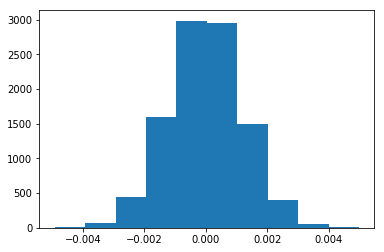

In [27]:
p_diffs = np.array(p_diffs)
#Observe the distribution of p_diffs
plt.hist(p_diffs)
plt.show()

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
actual_diff = p_treament_convert - p_control_convert

#Calculate proportion of p_diffs values that are greater than previously observed actual difference
proportion = (p_diffs > actual_diff).mean()
proportion

0.90680000000000005

k. Observations:

#### Part j computes the probability of the event new page conversion > old page conversion given old page conversion >= new page conversion.

#### The value computed is called p value, if the p value < alpha (0.05), the difference is said to be significant between new page conversion and old page conversion. In this case, p value > alpha, which means we fail to reject Null.

l. Test the results with statsmodels library.

In [29]:
import statsmodels.api as sm

#Get conversion rates for both new page and old page users
convert_old = df2[(df2['converted'] == 1) & (df2['landing_page'] == 'old_page')].groupby('user_id').user_id.nunique().count()
convert_new = df2[(df2['converted'] == 1) & (df2['landing_page'] == 'new_page')].groupby('user_id').user_id.nunique().count()
#Get samples sizes for both new page and old page users
n_old = df2[df2['landing_page'] == 'old_page'].groupby('user_id').user_id.nunique().count()
n_new = df2[df2['landing_page'] == 'new_page'].groupby('user_id').user_id.nunique().count()
print("conversion with old page: ", convert_old)
print("conversion with new page: ", convert_new)
print("number received old pages: ", n_old)
print("number received new pages: ", n_new)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


conversion with old page:  17489
conversion with new page:  17264
number received old pages:  145274
number received new pages:  145310


m. Use `stats.proportions_ztest` to compute test statistic and p-value.

In [30]:
#Calculate z score and p_value
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = 'larger')
print("z score: ", z_score)
print("p value: ", p_value)

z score:  -1.31092419842
p value:  0.905058312759


n. Observation:

#### z score measures the number of standard deviations between new page conversion and old page conversion. With alpha = 0.05, the critical z score is 1.64. If computed z score is larger than the critical z score, the Null will be rejected. In this case, computed z score < critical z score, we fail to reject the Null. It also means that the company should be advised to keep using the old page.

#### p value (one-tail) measures the probability of the event new page conversion > old page conversion (Alternative) given that the event  old page conversion >= new page conversion (Null) is true. With alpha = 0.05, if p value < alpha, the Null will be rejected. In this case, p value  >  0.05, we fail to reject the Null. It also means that the company should be advised to keep using the old page.

#### The results in j and k agree.

<a id='regression'></a>
### Part III - A regression approach

`1.` Achieve the same results through a regression <br><br>

a. Logistic Regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
#Create intercept
df2['intercept'] = 1
#Create 2 columns to process group column, use 'holder' as the unused column, 'ab_page' as the testing column
#for treatment as 1 and control as 0
df2[['holder', 'ab_page']] = pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,holder,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


c. Fit the model.

In [32]:
#Fit logistic model for the intercept and page
model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Model summary.

In [33]:
#Show statistic output
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 02 Jan 2019   Pseudo R-squ.:               8.077e-06
Time:                        18:17:03   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. Observation:

#### The p value computed here is 0.19, it differs from the value above because Logistic Regression assumes a two-tail test with:

**Null**: There is no difference between new page conversion and old page conversion

**Alternative**: There is a difference between new page conversion and old page conversion

#### Part II calculations assume a one-tail test with Alternative being new page conversion > old page conversion.

f. Other factors:

#### Other factors that may influence whether or not an individual converts could include timing of conversion (seasonality) and age group of users. If the website sells commercial products, the conversion rates may differ significantly during the holidays because users tend to prefer red elements during the holidays, but not so much on normal days. If old page happens to contain red elements and the test period is near holidays, it could mislead the test results. Also, age groups may play a role in converting on old page over new page. If the treatment group happens to contain many older users, it could be possible that they will prefer old page due to change aversion. 

#### Adding additional terms may require furthur data processing to remove variables conlinearity, longer test periods, greater sample sizes, and more user information, which together reduces test praticality. 

g. Does country had an impact on conversion?

In [35]:
#Read countries.csv to dataframe and perform a left join with df2 to preserve all rows in df2 and join on the same user ids
country = pd.read_csv("countries.csv")
combined = pd.merge(df2, country, how="left", left_on = "user_id", right_on = "user_id")
combined[['CA', 'UK', 'US']] = pd.get_dummies(combined['country'])

#Fit logistic regression on new model adding 2 of the 3 country variables
new_model = sm.Logit(combined['converted'], combined[['intercept', 'CA', 'UK']])
new_result = new_model.fit()
new_result.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Wed, 02 Jan 2019   Pseudo R-squ.:               1.521e-05
Time:                        18:17:46   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

Observation:
    
---
#### It does not seem that country had an impact on conversion because both CA and UK show p values greater than alpha (0.05).

h. Summary output.

In [36]:
#Create interaction between page and CA, and page and UK
combined['page_CA'] = combined['ab_page'] * combined['CA']
combined['page_UK'] = combined['ab_page'] * combined['UK']

#Fit logistic regression on interact model adding the 2 interact terms, 2 of the 3 countries and page
interact_model = sm.Logit(combined['converted'], combined[['intercept', 'ab_page', 'CA', 'UK', 'page_CA', 'page_UK']])
interact_result = interact_model.fit()
interact_result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 02 Jan 2019   Pseudo R-squ.:               3.482e-05
Time:                        18:19:29   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
page_CA       -0.0469      0.054     -0.872      0.383      -0.152       0.059
page_UK        0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

Observation:

---
#### It seems that the interaction between page and country also does not have impact on conversions because their p values > 0.05.

Conclusion:
    
#### Based on the test results, it is recommended that the company keep using the old page because the new page did not generate significant conversion difference. However, it is worth exploring furthur the reasons behind why new page does not improve conversion, and whether conversion alone is a good enough metric for the company to make an implementation decision.

#### It is possible that there are technical difficulties causing user to not load the new page properly, which in term prevents conversion, should the company resolve this issue and perform another test, we may see a very different outcome. It is also possible that each converted user for the new page generated more revenues for the company (bought more expensive products, etc,.), the company would be better off to conduct a more in-depth research while applicable  than making a decision based on this test alone. 